In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from radam import RAdam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, SimpleRNN, GRU,Input
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import os

c:\Hallym\Search\YoutubeDATA\testenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# make dummy column on my way
def make_dummy_category(data):
    for i in range(27):
        data[f"category_{i+1}"] = [1 if category == (i+1) else 0 for category in data['category_id']]
    return data

In [3]:
def categorize_duration(duration):
    if duration <= 60:
        return 0
    elif duration <= 240:
        return 1
    elif duration <= 1200:
        return 2
    else:
        return 3

In [5]:
# Convert the data to a 2D array for training the LSTM model
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(1,len(data)):
        end_ix = i + n_steps
        if end_ix >= len(data):
            break
        # extract the input and output sequences
        seq_X, seq_y = data.iloc[i:end_ix, :-1].values, data.loc[end_ix, ['views_diff_scaled','likes_diff_scaled']]
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
#학습데이터 구성

# set the directory path containing the CSV files
directory = 'DATA/video_daily_preprocessed'
filenames= os.listdir(directory)
# columns = ['category_id', 'duration', 'update_diff', 'views_scaled', 'likes_scaled','time_gap_minutes']
# columns = ['category_id', 'duration', 'update_diff', 'views_scaled', 'likes_scaled','time_gap_minutes']
columns = ['category_id', 'duration', 'views_diff_scaled', 'likes_diff_scaled','update_diff']

# set the desired n_steps and threshold values
n_steps = 3
threshold = 43200
initX, inity = np.zeros((1,3,6)), np.zeros((1,2))
X = np.zeros((1,3,6))
Y = np.zeros((1,2))

# iterate over the files in the directory
for filename in filenames:
    # load the CSV file
    filepath = os.path.join(directory, filename)
    data = pd.read_csv(filepath)
    data = data[columns]

    #simple pre-processing to make one hot vector for category.
    data = make_dummy_category(data)
    data.drop(['category_id'],axis=1,inplace=True)
    data['duration'] = data['duration'].apply(categorize_duration)

    if data.isnull().any().any():
        # print(f"there is null in {filename}")
        continue

    # prepare the data using the prepare_data() function
    tmpX, tmpy = prepare_data(data, n_steps=n_steps)
    # print(f"{filename}, x: {X.shape}, tmpx: {tmpX.shape}")
    if not np.array_equal(X,initX):
        if (tmpX.shape[1:3] == X.shape[1:3]):
            X = np.concatenate((X,tmpX),axis=0)
            Y = np.concatenate((Y,tmpy),axis=0)
    else:
        X = tmpX
        Y = tmpy

In [7]:
#make tensorflow model

def make_CNN_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1))

    return model

def make_RNN_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(1,activation='sigmoid'))  # Output layer with single neuron for regression

    return model

def make_Transformer_model(input_shape):
    # Define the Transformer model
    inputs = Input(shape=input_shape)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    output = Dense(1)(attention_output)

    model = Model(inputs=inputs, outputs=output)

    return model

def make_GRU_model(input_shape):
    # Define the GRU model
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    return model

def make_LSTM_model(input_shape):
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(2))

    return model

In [9]:
X.shape

(155, 3, 30)

In [10]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


# Define the model
# model = make_RNN_model((X_train.shape[1],X_train.shape[2]))
# model = make_CNN_model((X_train.shape[1],X_train.shape[2]))
# model = make_GRU_model((X_train.shape[1],X_train.shape[2]))
model = make_LSTM_model((X_train.shape[1],X_train.shape[2]))
# model = make_Transformer_model((X_train.shape[1],X_train.shape[2]))



loss = MeanSquaredError()
metrics = [MeanAbsoluteError()]

# Compile the model
mySGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.3,weight_decay=0.001,nesterov=True)
myRMS = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-06)
myAdam = Adam(learning_rate=0.001)
myRAdam = tfa.optimizers.RectifiedAdam(learning_rate=0.01,weight_decay=0.001,beta_1=0.95)

model.compile(optimizer=myRAdam, loss=loss, metrics=metrics)

# Train the L model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.2)

Epoch 1/100
3/3 - 2s - loss: 10.1182 - mean_absolute_error: 1.3986 - val_loss: 12.2466 - val_mean_absolute_error: 2.3392 - 2s/epoch - 602ms/step
Epoch 2/100
3/3 - 0s - loss: 9.5695 - mean_absolute_error: 1.2370 - val_loss: 11.6872 - val_mean_absolute_error: 2.2514 - 26ms/epoch - 9ms/step
Epoch 3/100
3/3 - 0s - loss: 9.3691 - mean_absolute_error: 1.1655 - val_loss: 11.5810 - val_mean_absolute_error: 2.2344 - 24ms/epoch - 8ms/step
Epoch 4/100
3/3 - 0s - loss: 9.2362 - mean_absolute_error: 1.1549 - val_loss: 11.4366 - val_mean_absolute_error: 2.2111 - 30ms/epoch - 10ms/step
Epoch 5/100
3/3 - 0s - loss: 9.2541 - mean_absolute_error: 1.1345 - val_loss: 11.2640 - val_mean_absolute_error: 2.1828 - 30ms/epoch - 10ms/step
Epoch 6/100
3/3 - 0s - loss: 9.1892 - mean_absolute_error: 1.0939 - val_loss: 11.0701 - val_mean_absolute_error: 2.1500 - 37ms/epoch - 12ms/step
Epoch 7/100
3/3 - 0s - loss: 9.0065 - mean_absolute_error: 1.0923 - val_loss: 10.8589 - val_mean_absolute_error: 2.1166 - 30ms/epoch

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=321)

def make_model(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-8,weight_decay=0.01):
    model = make_LSTM_model((X_train.shape[1],X_train.shape[2]))
    myRAdam = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate,beta_1=beta_1,beta_2=beta_2,epsilon=epsilon,weight_decay=weight_decay)
    model.compile(optimizer=myRAdam, loss='mean_squared_error')

    return model
    
model = KerasRegressor(build_fn=make_model, verbose=1)
# Define the scoring metric
scoring = 'neg_mean_squared_error'

param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.999, 0.9999],
    'epsilon': [1e-8, 1e-7, 1e-6],
    'weight_decay': [0.01,0.001,0.0001]
}
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)

# Perform the grid search
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

C:\Users\a5267\AppData\Local\Temp\ipykernel_20120\1759649108.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=make_model, verbose=1)


158/158 [==============================] - 1s 1ms/step - loss: 0.8205
Best Hyperparameters: {'beta_1': 0.95, 'beta_2': 0.999, 'epsilon': 1e-08, 'learning_rate': 0.01, 'weight_decay': 0.001}


In [8]:
model.evaluate(X_test,Y_test)

181/181 [==============================] - 0s 728us/step - loss: 0.4969 - mean_absolute_error: 0.4687


[0.4968569576740265, 0.4686717092990875]

In [12]:
from keras.models import load_model
model.save('daily_model.h5')

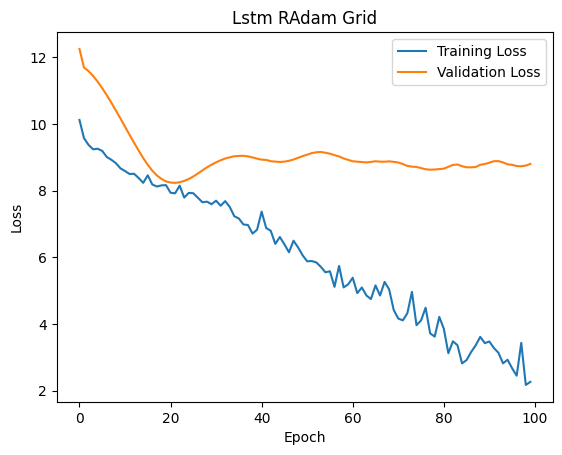

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Lstm RAdam Grid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(3, 30)
1/1 [==============================] - 0s 16ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [==============================] - 0s 16ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 16ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 18ms/step
(3, 30)
1/1 [===========================

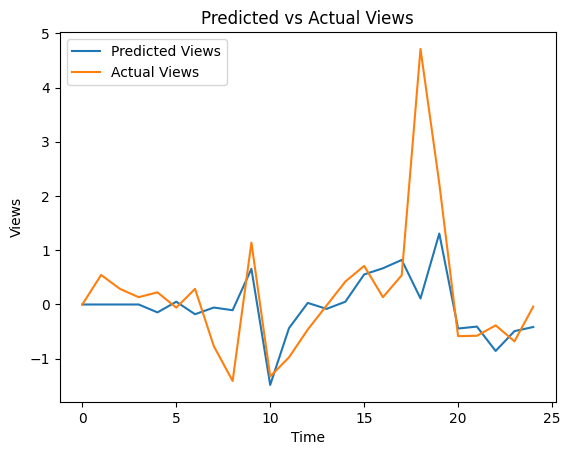

In [18]:
import matplotlib.pyplot as plt

# Assuming you have your predicted values in a variable called 'predicted_views'
# and actual values in a variable called 'actual_views'


# data = pd.read_csv('fortestpredict.csv')

data = pd.read_csv(r'드디어 WebGPU 혁명이 왔다_0516_1.csv')
columns = ['category_id', 'duration', 'views_diff_scaled', 'likes_diff_scaled','hour']
data = data[columns]
data = make_dummy_category(data)
data.drop(['category_id'],axis=1,inplace=True)
data['duration'] = data['duration'].apply(categorize_duration)
x, y = prepare_data(data,3)
actual_views = np.array(data['views_diff_scaled'])
actual_likes = np.array(data['likes_diff_scaled'])
predicted_views = [0] * (len(actual_views)-len(x))
predicted_views = [0] * (len(actual_views)-len(x))

for tmpx in x:
    predicted = model.predict(tmpx.reshape(1,3,30))[0]
    predicted_views.append(predicted[0])
    predicted_likes.append(predicted[1])

# Get the time index for plotting
time_index = range(len(predicted_views))

# Plot the predicted views and actual views
plt.plot(time_index, predicted_views, label='Predicted Views')
plt.plot(time_index, actual_views, label='Actual Views')

# Set labels and title for the graph
plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Predicted vs Actual Views')

# Add a legend
plt.legend()

# Display the graph
plt.show()

In [17]:
model.predict(x[0].reshape(1,3,30))[0][0]

1/1 [==============================] - 0s 18ms/step


-0.14541984